# Experiments on Returns on Investment

*An introduction to the delta method for inference on ratio metrics.*

When we run an experiment, we are often not only interested in the effect of a treatment (new product, new feature, new interface, ...) on revenue, but in it's **cost-effectiveness**. In other words, is the investment worth the cost? Common examples include investments in computing resources, returns on advertisement, but also click-through rates and other ratio metrics.  

When we investigate causal effects, the gold standard are randomized control trials, a.k.a. **AB tests**. Randomly assigning the treatment to a subset of the population (users, patients, customers, ...) we ensure that, on average, the difference in outcomes can be attributed to the treatment. However, when the object of interest is cost-effectiveness, AB tests present some additional problems since we are not just interested in one treatment effect, but in the **ratio of two treatment effects**, the outcome of the investment over its cost.

In this post we are going to see how to do inference when the object of interest is the **return on investment (ROI)**. We are going to explore alternative metrics to measure whether an investment paid off. We will also introduce a very powerful tool for inference with complex metrics: the **delta method**. While the algebra can be intense, the result is simple: we can compute the confidence interval for our ratio estimator using a simple linear regression. 

## Investing in Cloud Computing

To better illustrate the concepts, we are going to use a toy example throughout the article: suppose we were an **online marketplace** and we wanted to **invest in cloud computing**: we want to increase the computing power behind our internal search engine, by switching to a higher tier server. The idea is that the faster search will improve the user experience, potentially leading to higher sales. Therefore, the question is: is the investment worth the cost? The object of interest is the **return on investment (ROI)**.

Differently from usual AB tests or randomized experiments, we are not interested in a single causal effect, but in the **ratio** of two metrics: the effect on revenue and the effect on cost. We will still use a **randomized control trial** or **AB test** to estimate the ROI: we randomly assign groups of users to either the treatment or the control group. The treated users will benefit from the faster cloud machines, while the control users will use the old slower machines. Randomization ensures that we can estimate the impact of the new machines on either cost or revenue by comparing users in the treatment and control group: the difference in their average is an unbiased estimator of the average treatment effect. However, things are more complicated for their ratio.

I import the data generating process `dgp_cloud()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). With respect to previous articles, I generated a new DGP parent class that handles randomization and data generation, while its children classes contain the specific use-cases. I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).  To include not only code but also data and tables, I use [Deepnote](https://deepnote.com), a Jupyter-like web-based collaborative notebook environment. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.utils import *
from src.dgp import dgp_cloud, DGP

In [27]:
dgp = dgp_cloud(n=10_000)
df = dgp.generate_data(seed_assignment=6)
df.head()

,new_machine,cost,revenue
0,1,3.14,20.90
1,0,3.77,33.57
2,1,3.16,24.31
3,0,2.36,20.35
4,0,1.65,12.60


The data contains information on the total `cost` and `revenue` for a set of $10.000$ users over a period of a month. We also have information on the treatment: whether the search engine was running on the old or `new machines`.  As it often happens with business metrics, both distributions of cost and revenues are very **skewed**. Moreover, most people do not buy anything and therefore generate zero revenue, even though they still use the platform, generating positive costs.

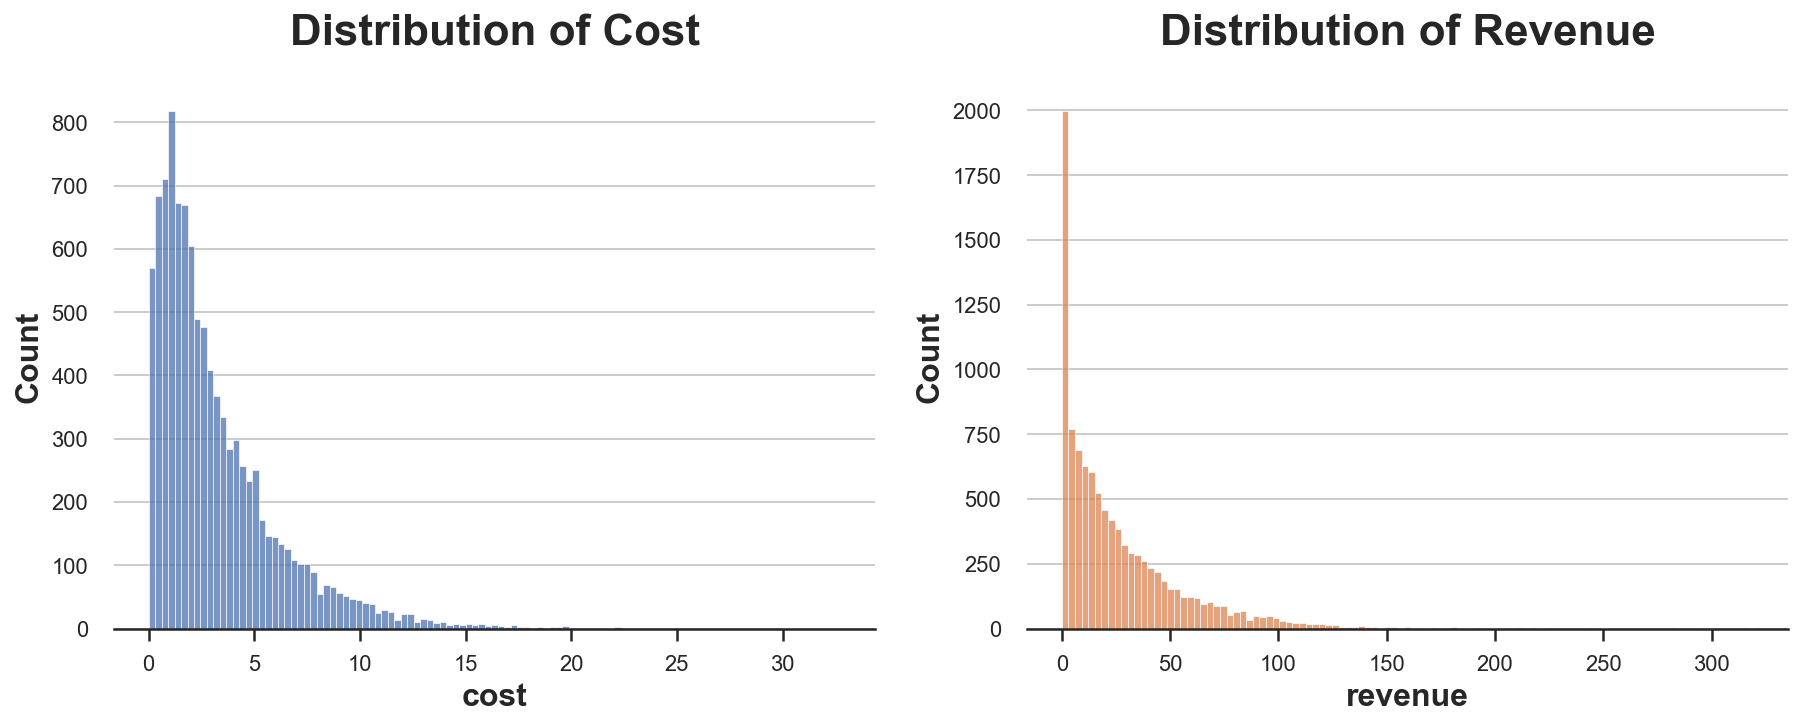

In [28]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df.cost, ax=ax1, color='C0').set(title='Distribution of Cost')
sns.histplot(df.revenue, ax=ax2, color='C1').set(title='Distribution of Revenue');

We can compute the **difference-in-means** estimate for `cost` and `revenue` by regressing the outcome on the treatment indicator.

In [29]:
smf.ols('cost ~ new_machine', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9617,0.043,69.034,0.000,2.878,3.046
new_machine,0.5152,0.060,8.563,0.000,0.397,0.633


The average `cost` has increased by $0.5152\$$ per user. What about revenue?

In [30]:
smf.ols('revenue ~ new_machine', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,25.9172,0.425,60.950,0.000,25.084,26.751
new_machine,1.0664,0.596,1.788,0.074,-0.103,2.235


The average `revenue` per user has also increased, by $1.0664\$$. So, was the investment **profitable**? 

To answer this question, we first have to decide which metric to use as our **outcome metric**. In case of ratio metrics, this is not trivial.

## Average Return or Return of the Average?

It is very tempting to approach this problem saying: it is true that we have two variables, by we can just compute their ratio, and then analyze everything as usual, using a **single variable**: the individual level return.

$$
\rho_i = \frac{\text{individual revenue}}{\text{individual cost}} = \frac{R_i}{C_i}
$$

What happens if we analyze the experiment using this single metric?

In [31]:
df["rho"] = df["revenue"] / df["cost"]
smf.ols("rho ~ new_machine", df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.6898,0.044,150.832,0.000,6.603,6.777
new_machine,-0.7392,0.062,-11.893,0.000,-0.861,-0.617


The estimated effect is **negative and significant**, $-0.7392$! It seems like the the new machines were not a good investment, and the returns have decreased by $74\%$.

This result seems to contradict our previous estimates. We have seen before that the revenue has increased on average more than the cost ($0.9505$ vs $0.5076$). Why is it the case? The problem is that we are giving the same weight to heavy users and light users. Let's use a simple example with two users. The first one (blue) is a light user and before was costing $1\$$ and returning $10\$$, while now is costing $4\$$ and returning $20\$$. The other user (violet) is a heavy user and before was costing $10\$$ and returning 100\\$ and now is costing $20\$$ and returning $220\$$. 

<img src="fig/return.png" width="700px"/>

The average return is -3x: on average the return per user has decreased by $300\%$. However, the total return per user is $1000\%$: the increase in cost of $13\$$ has generated $130\$$ in revenue! The results are wildly different and entirely driven by the weight of the two users: the effect of the heavy user is low in relative terms but high in absolute terms, while it's the opposite for the light user. The average relative effect is therefore mostly driven by the light user, while the relative average effect is mostly driven by the heavy user.

**Which metric** is more relevant in our setting? We talking about return on investment, we are usually interested in understanding whether we got a return on the money we spend. Therefore, the **total return** is more interesting than the average return.

From now on, the object of interest will be the **return on investment (ROI)**, given by the expected increase in revenue over the expected increase in cost, and we will denote it with the greek letter rho, $\rho$.

$$
\rho = \frac{\text{incremental revenue}}{\text{incremental cost}} = \frac{\mathbb E [\Delta R]}{\mathbb E [\Delta C]}
$$

We can estimate the ROI as the ratio of the two previous estimates: the average difference in revenue between the treatment and control group, over the average difference in cost between the treatment and control group.

$$
\hat{\rho} = \frac{\mathbb E_n [\Delta R]}{\mathbb E_n [\Delta C]}
$$

Note a subtle but crucial difference with respect to the previous formula: we have replaced the [expected values](https://en.wikipedia.org/wiki/Expected_value) $\mathbb E$ with the empirical expectation operators $\mathbb E_n$, also known as the [sample average](https://en.wikipedia.org/wiki/Arithmetic_mean). The difference in notation is minimal, but the conceptual difference is huge. The first, $\mathbb E$, is a **theoretical** concept, while the second, $\mathbb E_n$, is **empirical**: it is a number that depends on the actual data. I personally like the notation since it highlights the close link between the two concepts (the second is the empirical counterpart of the first), while also making it clear that the second crucially depends on the sample size $n$.

In [32]:
def estimate_roi(df):
    Delta_C = df.loc[df.new_machine==1, "cost"].mean() - df.loc[df.new_machine==0, "cost"].mean()
    Delta_R = df.loc[df.new_machine==1, "revenue"].mean() - df.loc[df.new_machine==0, "revenue"].mean()
    return Delta_R / Delta_C

estimate_roi(df)

2.0698235970047887

The estimate is $2.0698$: each additional dollar spent in the new machines translated in $2.0698$ extra dollars in revenue. Sounds great!

But how much should we trust this number? Is it significantly different form one, or it is just driven by noise?

## Inference

To answer this question, we would like to compute a [**confidence interval**](https://en.wikipedia.org/wiki/Confidence_interval) for our estimate. How do we compute a confidence interval for a ratio metric? The first step is to compute the standard deviation of the estimator. One method that is always available is the [**bootstrap**](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)): resample the data with replacement multiple and times and use the distribution of the estimates over samples to compute the standard deviation of the estimator.

Let's try it in our case. I compute the standard deviation over $10.000$ bootstrapped samples, using the function `pd.DataFrame().sample()` with the options `frac=1` to obtain a dataset of the same size and `replace=True` to sample with replacement.

In [33]:
boot_estimates = [estimate_roi(df.sample(frac=1, replace=True, random_state=i)) for i in range(10_000)]
np.std(boot_estimates)

0.9790730538161984

The bootstrap estimate of the standard deviation is equal to $0.979$. How good is it?

Since we fully control the data generating process, we can simulate the "true" distribution of the estimator. We do that for $10.000$ simulations and we compute the resulting standard deviation of the estimator.

In [34]:
np.std(dgp.evaluate_f_redrawing_outcomes(estimate_roi, 10_000))

1.0547776958025372

The estimated variance of the estimator using the "true" data generating process is slightly higher but very similar, around $1.055$. 

The issue with the bootstrap is that it is very computational intense since it requires repeating the estimating procedure thousands of times. We are now going to explore another *extremely* powerful alternative that requires a single estimation step, the [**delta method**](https://en.wikipedia.org/wiki/Delta_method). The delta method generally allows us to do inference on functions of random variable, therefore it's applications are broader than ratios. 

⚠️ **Warning**: the next section is going to be algebra-intense. If you want, you can skip it and go straight to the last section.

## The Delta Method

What is the **delta method**? In short, it is an incredibly powerful **asymptotic inference** method for functions of random variables, that exploits Taylor expansions. In short, the Delta Method requires four ingredients

- One or more [random variables](https://en.wikipedia.org/wiki/Random_variable)
- A function
- [The Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)
- [Taylor expansions](https://en.wikipedia.org/wiki/Taylor_series)

I will assume some basic knowledge of all four concepts. Suppose we had a set of realizations $X_1$, ..., $X_n$ of a random variable that satisfy the requirements for the Central Limit Theorem (CLT): independence, identically distributions with expected value $\mu$, and finite variance $\sigma^2$. Under these conditions, the CLT tells us that the sample average $\mathbb E_n[X]$ converges in distribution to a normal distribution, or more precisely

$$
\sqrt{n} \ \frac{ \mathbb E_n[X] - \mu}{\sigma} \ \overset{D}{\to} \ N(0, 1)
$$

What does the equation mean? It reads "the normalized sample average, scaled by a factor $\sqrt{n}$, converges in distribution to a standard normal distribution, i.e. it is approximately Gaussian for a sufficiently large sample.

Now, suppose we were interested in a **function** of the sample average $f\big(\mathbb E_n[X]\big)$. Note that this is different from the sample average of the function $\mathbb E_n\big[f(X)\big]$. The delta method tells us what the function of the sample average converges to. 

$$
\sqrt{n} \ \frac{ f\big(\mathbb E_n[X]\big) - f(\mu)}{\sigma} \ \overset{D}{\to} \ N \big(0, f'(\mu)^2 \big)
$$

, where $f'(\mu)^2$ is the derivative of the function $f$, evaluated at $\mu$.

What is the **intuition** behind this formula? We now have a new term inside the expression of the variance, the squared first derivative $f'(\mu)^2$ ($\neq$ second derivative). If the derivative of the function is low, the variance decreases since different inputs translate into similar outputs. On the contrary, if the derivative of the function is high, the variance of the distribution is amplified, since different inputs translate into even more different outputs.

<img src="fig/delta_intuition.png" width="700px"/>

The result directly follows from the Taylor approximation of $f \big(\mathbb E_n[X]\big)$

$$
f\big(\mathbb E_n[X]\big) = f(\mu) + f'(\mu) (\mathbb E_n[X] - \mu) + \text{residual}
$$

Importantly, asymptotically, the last term disappears and the linear approximation holds exactly!

How is this connected to the ratio estimator? We need a bit more math and to switch from a single dimension to two dimensions in order to understand that. In our case, we have a bivariate function of two random variables, $\Delta R$ and $\Delta C$, which returns their ratio. In the case of a multivariate function $f$, the asymptotic variance of the estimator is given by

$$
\text{AVar} \big( \hat{\rho} \big) = \nabla \hat{\rho}' \Sigma_n \nabla \hat{\rho}
$$

where, $\nabla$ indicates the [gradient](https://en.wikipedia.org/wiki/Gradient) of the function, i.e. the vector of directional derivatives, and $\Sigma_n$ is the empirical variance-covariance matrix of $X$. In our case, they correspond to

$$
\nabla \hat{\rho} = 
\begin{bmatrix} 
\frac{1}{\mathbb E_n [\Delta C]} \newline - \frac{\mathbb E_n [\Delta R]}{\mathbb E_n [\Delta C]^2}
\end{bmatrix}
$$

and

$$
\Sigma_n = 
\begin{bmatrix}
\text{Var}_n (\Delta R) & \text{Cov}_n (\Delta R, \Delta C) \newline
\text{Cov}_n (\Delta R, \Delta C) & \text{Var}_n (\Delta C) \newline
\end{bmatrix}
$$

, where the subscripts $n$ indicate the empirical counterparts, as for the expected value. 

Combining the previous three equations together with a little matrix algebra, we get the formula of the asymptotic variance of the return on investment estimator.

$$
\begin{align*}
\text{AVar} \big( \hat{\rho} \big) &= \frac{1}{\mathbb E_n[\Delta C]^2} \text{Var}_n(\Delta R) - 2 \frac{\mathbb E_n[\Delta R]}{\mathbb E_n[\Delta C]^3} \text{Cov}_n(\Delta R, \Delta C) + \frac{\mathbb E_n[\Delta R]^2}{\mathbb E_n[\Delta C]^4} \text{Var}_n(\Delta C)
\end{align*}
$$

Since the estimator is given by $\hat{\rho} = \frac{\mathbb E_n[\Delta R]}{\mathbb E_n[\Delta C]}$, we can rewrite the asymptotic variance as

$$
\begin{align*}
\text{AVar} \big( \hat{\rho} \big) = \frac{1}{\mathbb E_n[\Delta C]^2} \text{Var}_n \Big( \Delta R - \hat{\rho} \Delta C \Big)
\end{align*}
$$

The last expression is very interesting because it suggests that we can rewrite the asymptotic variance of our estimator as the **variance of a difference-in-means estimator** for a new auxiliary variable. In fact, we can rewrite the above expression as

$$
\begin{align*}
\text{AVar} \big( \hat{\rho} \big) = \text{Var}_n \Big( \Delta \tilde R \Big) \qquad \text{where} \quad \tilde R = \frac{R - \hat{\rho} \ C}{| \mathbb E [\Delta C] |}
\end{align*}
$$

This expression is incredibly useful because it gives us intuition and allows us to estimate the standard deviation of our estimator by **linear regression**.

## Inference with Linear Regression

Did you skip the previous section? No problem!

After some algebra, we concluded that we can estimate the variance of a difference-in-means estimator for an **auxiliary variable** defined as 

$$
\tilde R = \frac{R - \hat{\rho} \ C}{| \mathbb E_n [\Delta C] |}
$$

This expression might seem obscure at first, but it is incredibly useful. In fact, it gives us (1) an intuitive **interpretation** of the variance of the estimator and (2) a **practical** way to estimate it.

Interpretation first! How should we read the above expression? We can estimate the variance of the empirical estimator as the variance of a difference-in-means estimator, for a new variable $\tilde R$ that we can easily compute from the data. We just need to take the revenue $R$, subtract the cost $C$ multiplied by the estimated ROI $\rho$ and scale it down by the expected cost difference $|\mathbb E_n[\Delta C]|$. We can interpret this variable as the **baseline revenue**, i.e. the revenue not affected by the investment. The fact that it is scaled by the expected cost difference tells us that its variance will be **decreasing in the total investment**: the more we spend, the more precisely we can estimate the return on that expenditure.

Now, let's estimate the variance of the ROI estimator, in **four steps**.

1. We need to estimate the return on investment $\hat \rho$.

In [35]:
rho_hat = estimate_roi(df)

2. The term $| \mathbb E_n[\Delta C] |$ is the absolute difference in average cost between the treatment and control group.

In [36]:
abs_Delta_C = np.abs(df.loc[df.new_machine==1, "cost"].mean() - df.loc[df.new_machine==0, "cost"].mean())

3. We now have all the ingredients to generate the auxiliary variable $\tilde R$.

In [37]:
df['revenue_tilde'] = (df['revenue'] - rho_hat * df['cost']) / abs_Delta_C

4. The variance of the treatment-control difference $\Delta \tilde R$ can be directly computed by linear regression, as in randomized controlled trials for difference-in-means estimators (see Agrist and Pischke, 2008).

In [38]:
smf.ols('revenue_tilde ~ new_machine', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,38.4067,0.653,58.771,0.000,37.126,39.688
new_machine,-2.01e-14,0.917,-2.19e-14,1.000,-1.797,1.797


The estimated standard error of the ROI is $0.917$, very close to the bootstrap estimate of $0.979$ and the simulated value of $1.055$. However, with respect to bootstrapping, the delta method allowed us to compute it in a single step, making it sensibly **faster** (around $1000$ times on my local machine).

Note that this estimated standard deviation implies a 95\% confidence interval of $2.0698 +- 1.96 \times 0.917$, equal to $[-0.2735, 3.8671]$. This might seem like good news since the confidence interval does not cover zero. However, note that in this case, a more interesting **null hypothesis** is that the ROI is equal to 1: we are breaking even. A value larger than 1 implies profits, while a value lower than 1 implies losses. In our case, we cannot reject the null hypothesis that the investment in new machines was not profitable.

## Conclusion

In this article, we have explored a very common causal inference problem: assessing the **return on investment**. Whether it's a physical investment in new hardware, a virtual cost, or advertisement expenditure, we are interested in understanding whether this incremental cost has paid off. The additional complications come from the fact that we are studying not one, but two causal quantities, intertwined.

We have first explored and compared different outcome metrics to assess whether the investment paid off. Then, we have introduced an incredibly powerful method to do inference with complex random variables: the **delta method**. In the particular case of ratios, the delta method delivers a very insightful and practical functional form for the asymptotic variance of the estimator that can be estimated with a simple linear regression.

### References

[1] A. Deng, U. Knoblich, J. Lu, [Applying the Delta Method in Metric Analytics: A Practical Guide with Novel Ideas](https://arxiv.org/pdf/1803.06336.pdf) (2018).  

[2] R. Budylin, A. Drutsa, I. Katsev, V. Tsoy, [Consistent Transformation of Ratio Metrics for Efficient Online Controlled Experiments](https://dl.acm.org/doi/abs/10.1145/3159652.3159699) (2018). *ACM*.

[3] J. Angrist, J. Pischke, [Mostly harmless econometrics: An empiricist's companion](https://www.mostlyharmlesseconometrics.com/) (2009). *Princeton university press*.

### Related Articles

- [The Bayesian Bootstrap](https://medium.com/towards-data-science/the-bayesian-bootstrap-6ca4a1d45148)

- [Outliers, Leverage, Residuals, and Influential Observations](https://towardsdatascience.com/df3065a0388e)

- [A/B Tests, Privacy, and Online Regression](https://towardsdatascience.com/b07ab46aa782)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/delta.ipynb